# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy

In [2]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [4]:
from numpy.linalg import norm

class Perceptron:
    def __init__(self, iterations=100, learning_rate=1):
        self.w = None
        self.iterations = iterations
        self.learning_rate = learning_rate

    def fit(self, X, y):
        y = self.transform_y(y)
        X_with_one = np.hstack((np.ones(len(X)).reshape(1, -1).T, X))
        self.w = np.zeros(X_with_one.shape[1])                        
        
        iteration = 0
        while iteration < self.iterations:
            index = iteration % len(X)
            y_pred = np.sign(X_with_one[index] @ self.w)
            
            if y[index] != y_pred:
                self.w += y[index] * X_with_one[index] * self.learning_rate

            iteration +=1 
            
    def predict(self, X, with_one=False):
        if with_one is False: 
            X = np.hstack((np.ones(len(X)).reshape(1, -1).T, X))
        return np.array([self.to_old[val] for val in np.sign(X @ self.w)])

    def transform_y(self, y):
        values = np.unique(y)
        self.to_one = {values[0]: -1, values[1]: 1}
        self.to_old = {-1: values[0], 1: values[1]}
        return np.array([self.to_one[val] for val in y])

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

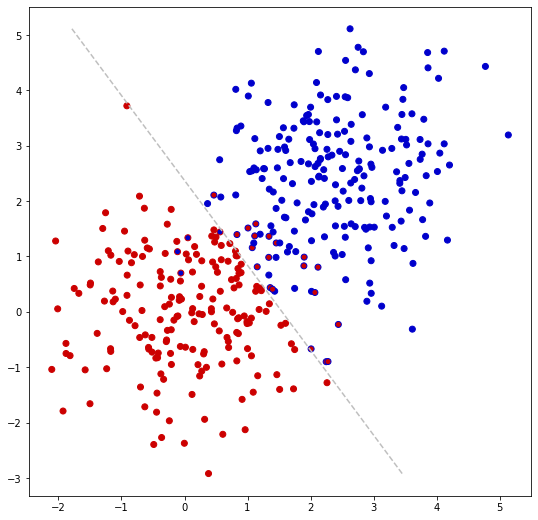

In [5]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron(iterations=1000, learning_rate=1/5)
c.fit(X, true_labels)
visualize(X, true_labels, c.predict(X), c.w)

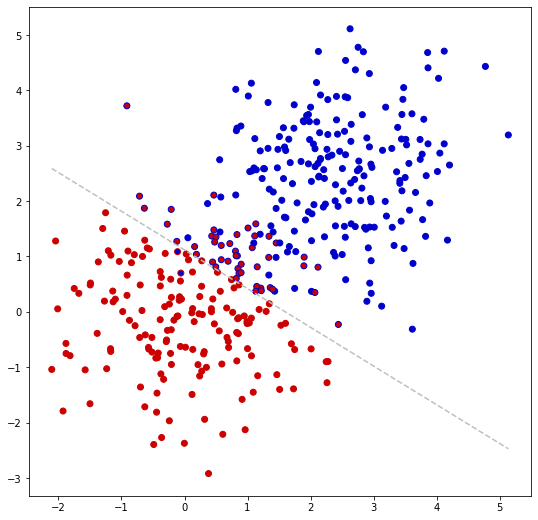

In [6]:
# X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [7]:
from sklearn.metrics import f1_score, accuracy_score

class PerceptronBest:
    def __init__(self, iterations=100, learning_rate=1, metric=accuracy_score):
        self.w = None
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.metric = metric

    def fit(self, X, y):
        y = self.transform_y(y)
        X_with_one = np.hstack((np.ones(len(X)).reshape(1, -1).T, X))
        self.w = np.zeros(X_with_one.shape[1])                        
        best_metric = 0
        iteration = 0
        
        while iteration < self.iterations:
            index = iteration % len(X)
            y_pred = np.sign(X_with_one[index] @ self.w)
            
            if y[index] != y_pred:
                self.w += y[index] * X_with_one[index] * self.learning_rate
                y_preds = np.sign(X_with_one @ self.w)
                value = self.metric(y_preds, y)
                if value > best_metric:
                    best_metric = value
                    best_w = self.w 

            iteration += 1
        
        self.w = best_w
            
    def predict(self, X, with_one=False):
        if with_one is False: 
            X = np.hstack((np.ones(len(X)).reshape(1, -1).T, X))
        return np.array([self.to_old[val] for val in np.sign(X @ self.w)])

    def transform_y(self, y):
        values = np.unique(y)
        self.to_one = {values[0]: -1, values[1]: 1}
        self.to_old = {-1: values[0], 1: values[1]}
        return np.array([self.to_one[val] for val in y])

In [8]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

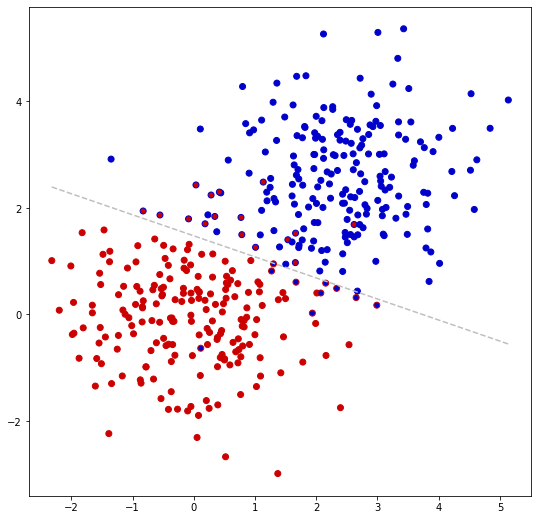

In [9]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

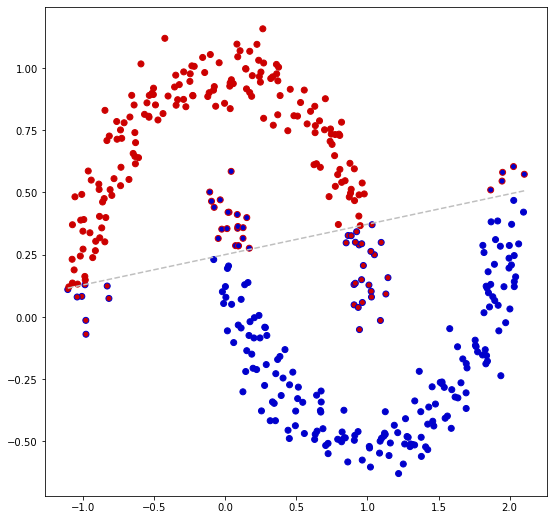

In [10]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest(iterations=10000,metric=f1_score)
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [11]:
from scipy.stats import entropy

def transform_images(images):
    """энтропия картинки, сумма дисперсий по 1 строки и 4ой по второй координате"""
    features = np.zeros((images.shape[0], 2))
    features[:, 0] = entropy(images, axis=(1,2))
    features[:, 1] = images[:, 1, :].var(axis=1) + images[:, 4, :].var(axis=1)# + np.argmax(images[:, 7, :], axis=1)
    return features

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
#     return images, labels
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [12]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

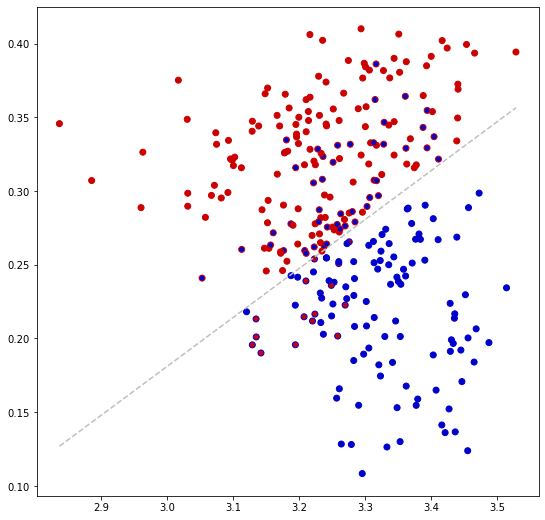

Accuracy: 0.8356164383561644


In [13]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

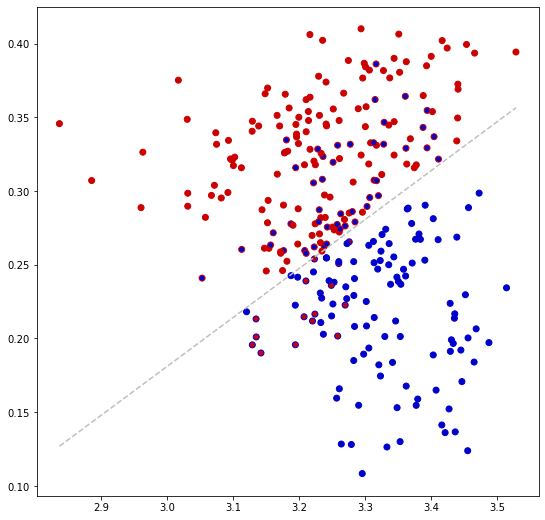

Accuracy: 0.8356164383561644


In [14]:
c = PerceptronBest(iterations=100000, metric=f1_score)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [15]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6100933607734688


In [16]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6100933607734688
